In [1]:
import tensorflow as tf
import keras 
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

dataset = torchvision.datasets.MNIST(root='./data', transform=transforms.ToTensor(), train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', transform=transforms.ToTensor(), train=False, download=True)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

Using TensorFlow backend.


In [2]:
def create_robust_dataset(size_of_dataset):
    import random
    random_batch_idx = (random.randint(0, len(loader)-1))
    samples, labels = None, None 
    for idx, (samples, labels) in enumerate(loader):
        if idx == random_batch_idx:
            samples = samples.reshape(-1, 784).numpy()
            labels = labels.numpy()
            samples = samples[:size_of_dataset]
            labels = labels[:size_of_dataset]
            break
    
    return samples, labels

def create_non_robust_dataset(size_of_dataset):
    import random
    random_batch_idx = (random.randint(0, len(loader)-1))
    samples, labels = None, None 
    for idx, (samples, labels) in enumerate(loader):
        if idx == random_batch_idx:
            samples = samples.reshape(-1, 784).numpy()
            labels = labels.numpy()
            samples = samples[:size_of_dataset]
            labels = labels[:size_of_dataset]
            break
    
    return samples, labels

def create_test_dataset(size_of_dataset):
    samples, labels = None, None 
    for idx, (samples, labels) in enumerate(loader):
        if idx == 0:
            samples = samples.reshape(-1, 784).numpy()
            labels = labels.numpy()
            samples = samples[:size_of_dataset]
            labels = labels[:size_of_dataset]
            break
    
    return samples, labels

    
size_of_dataset = 600
robust_X, robust_Y = create_robust_dataset(size_of_dataset)
print(robust_X.shape, robust_Y.shape)
non_robust_X, non_robust_Y = create_non_robust_dataset(size_of_dataset)
print(non_robust_X.shape, non_robust_Y.shape)
test_X, test_Y = create_test_dataset(size_of_dataset)
print(test_X.shape, test_Y.shape)

(600, 784) (600,)
(600, 784) (600,)
(600, 784) (600,)


In [3]:
from math import inf
from numpy.linalg import norm

num_classes = 10

def return_close_i(i, X_cluster_mean):
    min_j, min_distance = None, inf
    for j in range(len(X_cluster_mean)):
        if i != j:
            distance = norm(X_cluster_mean[j] - X_cluster_mean[i])
            if distance < min_distance:
                min_distance, min_j = distance, j
    return min_j, min_distance

def compute_robustness_indication(X, Y):
    X_cluster = []
    for class_idx in range(num_classes):
        cluster_array = [x for (idx, x) in enumerate(X) if Y[idx] == class_idx]
#         print('Length of cluster array:', len(cluster_array))
        try: 
            cluster = np.array(cluster_array)
        except: 
            print(cluster_array)
            cluster = np.array(cluster_array)
            print(cluster)
        X_cluster.append(cluster)
        
    
    X_cluster_mean = [np.mean(X, axis=0) for X in X_cluster]
    X_cluster_std = [np.std(X, axis=0) for X in X_cluster]

    r = 0
    for i in range(num_classes):
        close_i, close_i_distance = return_close_i(i, X_cluster_mean)
        print('close i:', close_i, 'close i distance:', close_i_distance)
        r += close_i_distance - norm(X_cluster_std[i]) - norm(X_cluster_std[close_i])
    return r

robust_r = compute_robustness_indication(robust_X, robust_Y)
non_robust_r = compute_robustness_indication(non_robust_X, non_robust_Y)

print('Robustness indication (robust dataset):', robust_r)
print('Robustness indication (non robust dataset):', non_robust_r)

close i: 5 close i distance: 4.518137
close i: 5 close i distance: 4.535229
close i: 8 close i distance: 3.4583333
close i: 5 close i distance: 3.1300032
close i: 9 close i distance: 2.8564155
close i: 3 close i distance: 3.1300032
close i: 5 close i distance: 3.809196
close i: 9 close i distance: 2.7265313
close i: 5 close i distance: 3.1902869
close i: 7 close i distance: 2.7265313
close i: 5 close i distance: 5.5771217
close i: 5 close i distance: 4.234166
close i: 6 close i distance: 4.2590165
close i: 5 close i distance: 3.422435
close i: 9 close i distance: 3.0634508
close i: 8 close i distance: 3.2289035
close i: 5 close i distance: 4.24055
close i: 9 close i distance: 3.7665422
close i: 5 close i distance: 3.2289035
close i: 4 close i distance: 3.0634508
Robustness indication (robust dataset): -94.54466962814331
Robustness indication (non robust dataset): -92.76857137680054


In [4]:
# Create two models corresponding to robust and non-robust dataset 
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class NaiveC(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 64)
        self.layer2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.relu(self.layer1(x))
        return self.layer2(output)

def generate_NaiveC(X, Y, verbose=False):
    model = NaiveC()

    # Optimizer parameters
    loss_func = nn.CrossEntropyLoss()
    lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_history = []
    
    # Training
    num_of_epochs = 20
    for epoch in range(num_of_epochs):
#         print(epoch+1, '/', num_of_epochs)
        for idx, data in enumerate(X):

            data = torch.from_numpy(np.expand_dims(data, axis=0).astype(np.float32))
            label = torch.from_numpy(np.array([Y[idx]]).astype(np.int64))
    
            # Forwarding
            prediction = model.forward(data)
            loss = loss_func(prediction, label)
            if verbose:
                print('Epoch:', epoch, 'Loss:', loss)

            # Optimization (back-propogation)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
            
    return loss_history, model
            
robust_loss_history, robust_model = generate_NaiveC(robust_X, robust_Y, verbose=True)
non_robust_loss_history, non_robust_model = generate_NaiveC(non_robust_X, non_robust_Y, verbose=True)

Epoch: 0 Loss: tensor(2.2125, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.2915, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.4001, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.2882, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.3756, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.4446, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.3847, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.3322, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.3666, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.1795, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.2190, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.4656, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.0275, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.0739, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.2770, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.6482, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.3703, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.9636, g

Epoch: 0 Loss: tensor(2.1703, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.7843, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3729, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.2846, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.5882, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.6324, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.8797, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.3038, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.6381, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.0826, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.8395, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.6719, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.9167, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.0357, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.7322, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.7278, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.4370, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.9313, g

Epoch: 0 Loss: tensor(2.0795, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.2604, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.2998, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.2446, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.7269, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.9911, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.4099, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.7872, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.8644, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3145, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.7096, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(6.0417, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.4792, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.7156, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.5084, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3283, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.1034, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.0062, g

Epoch: 0 Loss: tensor(0.3144, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3662, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.6072, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.3814, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.0795, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.2728, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3198, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.4620, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.2447, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.2303, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3703, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.2161, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(3.3900, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.4111, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.2844, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.8867, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.8038, g

Epoch: 1 Loss: tensor(2.3662, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1874, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.9381, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.1247, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.6534, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.6126, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.5547, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(2.2479, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.6022, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.5129, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0659, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2690, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1842, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.7034, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1004, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2303, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0862, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.1573, g

Epoch: 1 Loss: tensor(0.0345, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3039, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2793, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(2.6020, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(3.1284, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0165, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.5839, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1563, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0493, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0253, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1337, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2724, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3804, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.5612, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0311, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1052, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3814, g

Epoch: 1 Loss: tensor(0.1583, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3379, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.6528, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0051, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1092, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2280, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.5398, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(3.8249, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.5046, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(3.5397, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0132, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.2269, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.4833, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1808, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0706, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1406, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3663, g

Epoch: 1 Loss: tensor(0.6074, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0198, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0153, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.0440, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1213, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0993, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.6088, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0682, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3326, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0392, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2133, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.7779, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2085, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1222, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1418, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1088, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2366, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.7248, g

Epoch: 2 Loss: tensor(0.0295, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.3549, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1242, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.6278, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0086, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1093, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0438, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.4001, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1629, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0197, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2939, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.3339, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0707, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(3.6541, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0787, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0468, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0053, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.5651, g

Epoch: 2 Loss: tensor(0.0109, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1824, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0132, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1542, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(1.2139, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(2.7304, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.4884, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1603, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.3008, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0635, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(1.3132, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0730, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0106, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1564, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0795, g

Epoch: 2 Loss: tensor(0.1501, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0522, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0144, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0880, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2176, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2651, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0192, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1953, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.6709, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0536, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0047, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0168, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0153, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0082, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0471, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2414, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0053, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0963, g

Epoch: 2 Loss: tensor(0.0233, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2841, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0295, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0195, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.4407, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1193, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0201, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.4543, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1595, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0955, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.4248, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0240, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0442, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1245, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.6329, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0051, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0079, g

Epoch: 3 Loss: tensor(0.0377, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0761, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0267, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0042, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2048, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(3.7075, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1491, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1129, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0086, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0250, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2213, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.3300, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0122, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0365, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0343, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0045, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0631, g

Epoch: 3 Loss: tensor(0.0088, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0034, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0766, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1018, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0047, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0415, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(3.6168, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0025, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0529, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2833, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0848, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1651, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2068, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0487, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.4973, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0370, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.3356, g

Epoch: 3 Loss: tensor(0.1678, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1101, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1402, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.5022, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.7279, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0678, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0072, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0169, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0261, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0276, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0699, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0059, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0537, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0176, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0713, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0229, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0256, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0622, g

Epoch: 4 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0241, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1907, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.3690, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0045, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0553, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1606, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0249, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.3934, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0097, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0144, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0269, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.2167, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0094, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0220, g

Epoch: 4 Loss: tensor(0.0114, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0177, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.3270, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0923, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.3779, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1144, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0364, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1066, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0620, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0411, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0637, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.5886, g

Epoch: 4 Loss: tensor(0.4011, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0061, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(9.4052e-05, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1559, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0253, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0646, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0044, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0037, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0641, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0271, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0893, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0516, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0158, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0284, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.307

Epoch: 5 Loss: tensor(0.6910, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1464, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0473, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0194, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0215, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0241, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0655, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0396, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0068, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0170, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0112, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0352, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0605, g

Epoch: 5 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0246, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0442, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1915, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1170, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0782, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.5678, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0412, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0197, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.4160, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0437, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0187, g

Epoch: 6 Loss: tensor(0.9769, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0133, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0646, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0332, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0591, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.1642, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.4089, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0041, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0070, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0503, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.1705, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0198, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0075, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0355, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.1242, g

Epoch: 6 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0255, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0101, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0448, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(1.3113e-06, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0082, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0032, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0114, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0025, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.1270, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0053, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0124, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0661, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0264, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0053, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.006

Epoch: 6 Loss: tensor(0.0134, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0766, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(2.0981e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0989, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.1116, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0978, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0602, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0066, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0025, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(2.3484e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0071, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0

Epoch: 6 Loss: tensor(0.0276, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.2021, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0501, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0409, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0467, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0068, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0146, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0389, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0585, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0109, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.1643, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0018, g

Epoch: 7 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0052, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0035, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0085, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0145, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0060, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0644, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0058, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0053, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0913, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0032, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0078, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0410, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.016

Epoch: 7 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0406, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0075, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0193, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0070, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.1437, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0600, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0060, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0163, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.1366, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.1229, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0041, g

Epoch: 7 Loss: tensor(0.0672, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0057, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0194, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0457, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(3.4571e-06, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0191, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0061, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0160, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(9.4409e-05, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0243, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0

Epoch: 8 Loss: tensor(0.0694, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0052, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0503, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0052, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0138, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0044, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(3.6597e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0287, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.002

Epoch: 8 Loss: tensor(0.0035, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0055, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0050, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0034, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0109, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0060, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0037, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(6.5801e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0143, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.1225, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.005

Epoch: 8 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(8.3920e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0092, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0144, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0637, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0039, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0074, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0153, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0353, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.043

Epoch: 9 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0073, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0087, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0097, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0280, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0040, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0062, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(1.4305e-06, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0140, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(2.169

Epoch: 9 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(3.6239e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0051, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.2089, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(2.7418e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0374, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0032, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0062, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0089, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0376, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0031, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(1.8954e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0105, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tens

Epoch: 9 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0064, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0235, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(1.3113e-06, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0154, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0143, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0182, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0368, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0174, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.001

Epoch: 10 Loss: tensor(0.0090, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0383, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0141, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0052, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0177, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0132, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0094, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(5.7338e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0064, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 10 

Epoch: 10 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(7.9509e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0025, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(7.4622e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0049, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0032, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch:

Epoch: 10 Loss: tensor(0.0076, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(4.7684e-07, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(2.6464e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0100, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0134, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(7.0333e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0060, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0092, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(5.6504e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0175, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0023, grad_fn=<NllLossBackward>

Epoch: 11 Loss: tensor(1.2636e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0061, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0206, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0085, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0320, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0040, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0044, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0112, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(1.1921e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(1.0490e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0102, grad_fn=<NllLossBackward>

Epoch: 11 Loss: tensor(0.0154, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0209, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(4.2914e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(1.5259e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(3.3379e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(2.7895e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(9.0599e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0153, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0144, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0075, grad_fn=<NllLossBackw

Epoch: 12 Loss: tensor(5.1735e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.4305e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0148, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0047, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0139, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(8.3446e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.7881e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(9.8224e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0092, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0083, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0056, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0091, grad_fn=<NllLossB

Epoch: 12 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0079, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0175, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0030, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0075, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(2.5749e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 12 

Epoch: 12 Loss: tensor(0.0086, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0025, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(9.5367e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0034, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0025, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0064, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0041, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(7.8678e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0052, grad_fn=<NllLossBackward>)
Ep

Epoch: 13 Loss: tensor(1.9073e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0068, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(3.6001e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0031, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0108, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0101, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(2.9802e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0126, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch:

Epoch: 13 Loss: tensor(4.1484e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(4.8159e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0040, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(9.7747e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0117, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0056, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(3.7669e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(7.0333e-06, grad_fn=<NllLossB

Epoch: 14 Loss: tensor(0.0038, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(7.0450e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(8.8092e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(8.7973e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(7.1525e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(8.4158e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0002, grad_fn=<

Epoch: 14 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(5.4000e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(2.2530e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(2.2650e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0245, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(2.7418e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0002, grad_fn=<NllLossBackward>

Epoch: 14 Loss: tensor(2.7299e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(2.4557e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0041, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0044, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.0610e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0054, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(3.6835e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.7881e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(9.1310e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0042, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.1921e-06, grad_fn=<NllLossB

Epoch: 15 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(9.0599e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0058, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0025, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.6332e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(7.6887e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0032, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0035, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(5.6861e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(5.5908e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.7418e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(4.0531e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(5.7220e-06, grad_fn=<

Epoch: 15 Loss: tensor(1.2875e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0025, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0041, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(7.2717e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(9.5367e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.5497e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(4.7087e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.5034e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(6.6757e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(3.3379e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(4.6610e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0009, grad_

Epoch: 16 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(5.4835e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.1458e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(4.0411e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(3.6955e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.6941e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0030, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0031, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(5.2928e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0036, grad_fn=<NllLossB

Epoch: 16 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0046, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(5.6861e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(3.6955e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(5.5192e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(8.1297e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(9.2383e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(3.0517e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.0371e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0001, grad_

Epoch: 16 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(5.8412e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(6.9020e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.0265e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(6.0795e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.1682e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.7881e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(7.1525e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(7.1526e-07, grad_

Epoch: 17 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(8.8807e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(3.4571e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0030, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(6.0797e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.9563e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.3842e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.8491e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.2875e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.5497e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.7881e-06, grad_

Epoch: 17 Loss: tensor(8.3446e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(9.3933e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.9802e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.4305e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.1338e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(4.4107e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.3947e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0011, grad_fn=<

Epoch: 18 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(5.2212e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(4.7684e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.6451e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(2.1100e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.2159e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(9.2979e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.1086e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackw

Epoch: 18 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(4.3868e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.6689e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(7.3909e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(9.4175e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0016, grad_fn=<NllLossBackward>

Epoch: 18 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(6.8305e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(5.8053e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(8.4039e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(2.7299e-05, grad_fn=<NllLossBackward>)
Ep

Epoch: 19 Loss: tensor(1.3232e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(7.7483e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(4.7684e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(9.7985e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(4.6492e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(3.3974e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(8.5830e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(4.2914e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.1921e-07, grad_fn=<

Epoch: 19 Loss: tensor(2.9206e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(3.0517e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(3.6001e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.5497e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(4.5418e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.7179e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(3.8504e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(6.5565e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.3126e-05, grad_fn=<

Epoch: 0 Loss: tensor(2.5012, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.8748, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3182, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.2231, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.0051, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.0891, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.0555, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.4434, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3202, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.7812, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.6452, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3473, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.5948, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.3747, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.8530, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.2580, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.8685, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.6439, g

Epoch: 0 Loss: tensor(1.6393, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.3903, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.3588, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.3990, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.0761, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.1765, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.4777, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.1787, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.9584, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.2284, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.6646, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.2690, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.1249, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.4431, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(1.4157, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.4542, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(0.2097, grad_fn=<NllLossBackward>)
Epoch: 0 Loss: tensor(2.3679, g

Epoch: 1 Loss: tensor(0.3777, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(4.2314, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0050, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.6297, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3935, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.5604, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0283, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3117, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.5455, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.5244, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2392, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.6576, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.5673, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1818, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0060, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3455, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0159, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.9210, g

Epoch: 1 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2018, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(3.9200, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.2561, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0638, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0347, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(1.0732, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1214, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1426, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1036, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.1115, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0364, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(2.0372, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.0211, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3414, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.3947, grad_fn=<NllLossBackward>)
Epoch: 1 Loss: tensor(0.4743, g

Epoch: 2 Loss: tensor(0.1281, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2934, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1994, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0371, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0157, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(1.9176, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0641, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0475, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1635, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0103, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2515, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0488, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0111, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1529, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.3255, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0188, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0878, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(1.2924, g

Epoch: 2 Loss: tensor(0.0583, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1117, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0382, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0051, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.9348, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(1.2762, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(3.3378e-05, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1166, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0196, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2622, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(1.4425, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0091, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1901, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0121, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2220, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0615, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0367, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.181

Epoch: 2 Loss: tensor(3.8538, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0196, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1215, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1017, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0059, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2067, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(1.0199, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2318, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1091, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.1246, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0304, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.3111, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(2.5065, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0742, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.0441, grad_fn=<NllLossBackward>)
Epoch: 2 Loss: tensor(0.2201, g

Epoch: 3 Loss: tensor(0.0061, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0050, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0315, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2466, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2234, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1680, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0206, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0275, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1502, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0481, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0301, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0301, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.9587, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0063, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0618, g

Epoch: 3 Loss: tensor(0.5070, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1744, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0572, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.2158, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0785, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0058, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.3296, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1745, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.1926, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0794, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.4253, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0195, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0172, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 3 Loss: tensor(0.0289, g

Epoch: 4 Loss: tensor(1.2074, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1941, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0721, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0144, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0489, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0331, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0312, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0030, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0370, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0125, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0296, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0732, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0770, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0118, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0055, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0003, g

Epoch: 4 Loss: tensor(0.0040, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0105, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0273, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0051, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0337, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(6.9141e-06, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0855, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0713, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1733, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0595, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0095, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0868, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.1162, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.0052, grad_fn=<NllLossBackward>)
Epoch: 4 Loss: tensor(0.011

Epoch: 5 Loss: tensor(0.0182, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0633, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0634, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0220, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0090, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0365, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1079, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0327, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0229, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0032, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0147, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0042, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0215, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(7.6410e-05, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.149

Epoch: 5 Loss: tensor(0.0051, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0024, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0030, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(5.5908e-05, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0095, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0075, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1237, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0032, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0210, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0396, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0073, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0062, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0089, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1100, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.005

Epoch: 5 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0066, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0110, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0105, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0027, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0198, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0282, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0476, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(8.0463e-05, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0170, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0130, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.1534, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0105, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(2.5630e-05, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 5 Loss: tensor(0

Epoch: 6 Loss: tensor(0.0446, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0126, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0034, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0654, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(4.5179e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0497, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(1.4067e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0124, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0077, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0039, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.1551, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0

Epoch: 6 Loss: tensor(0.0194, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0108, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0596, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(2.9087e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0088, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0365, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0122, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0516, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(7.9748e-05, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.1936, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 6 Loss: tensor(0

Epoch: 7 Loss: tensor(0.0851, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0219, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0151, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0067, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0275, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(1.8358e-05, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0066, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0086, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0064, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(2.7418e-06, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(2

Epoch: 7 Loss: tensor(2.2769e-05, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0130, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0193, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(9.8820e-05, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0108, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0056, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0683, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(8.7019e-05, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0280, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0459, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0469, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tensor(0.0195, grad_fn=<NllLossBackward>)
Epoch: 7 Loss: tens

Epoch: 8 Loss: tensor(0.0123, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0038, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(2.7418e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(5.2093e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0192, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0148, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0135, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(4.5299e-06, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0049, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0034, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0266, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(7.9870e-06, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0252, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0194, grad_fn=<NllLossBackward>)
Epoch: 8 Lo

Epoch: 8 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(2.0266e-06, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0326, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0065, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(9.0599e-06, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0090, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0032, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0134, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0

Epoch: 8 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0165, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0792, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0191, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0151, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0037, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0239, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0647, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0125, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(9.9177e-05, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0146, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0744, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 8 Loss: tensor(0.002

Epoch: 9 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0275, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0047, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0159, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(3.5763e-06, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0045, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0034, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0053, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0328, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(9.5840e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tens

Epoch: 9 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0266, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0371, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0050, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0120, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0058, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(1.8716e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0083, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(7.1526e-07, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0016, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(1.1921e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0124, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0203, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(5.5073e-05, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 9 Loss: 

Epoch: 10 Loss: tensor(0.0237, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0100, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(2.0504e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0049, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0162, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(3.3379e-06, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(3.5762e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0034, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(3.1471e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0., grad_fn=<NllLossBackward>)
Ep

Epoch: 10 Loss: tensor(0.0074, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0243, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(4.2080e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0070, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(1.3232e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(1.2755e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0060, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0052, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0039, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(2.4795e-05, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0250, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 10 Loss: tensor(6.4373e-06, grad_fn=<NllLossBackw

Epoch: 11 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0061, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0133, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(4.8876e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(9.4052e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0038, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(5.9605e-07, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0104, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0070, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0059, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>

Epoch: 11 Loss: tensor(1.4305e-06, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0053, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(6.0080e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0093, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(2.1696e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(9.2025e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(9.5367e-07, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0005, grad_fn=<NllLossB

Epoch: 11 Loss: tensor(0.0075, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0244, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(9.4528e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0043, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(2.7060e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0035, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0198, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(3.1590e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0007, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(4.5656e-05, grad_fn=<NllLossBackward>)
Epoch: 11 Loss: tensor(0.0010, grad_fn=<NllLossBackward>

Epoch: 12 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0072, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0051, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(2.6226e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0048, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0066, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(5.9605e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0072, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(8.4754e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(8.3205e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(7.4503e-05, grad_fn=<NllLossBackw

Epoch: 12 Loss: tensor(9.6316e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0143, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(8.7022e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0073, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(2.8014e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0031, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(4.0888e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(5.9604e-06, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(3.0040e-05, grad_fn=<NllLossBackward>)
Epoch: 12 Loss: tensor(2.1696e-05, grad_fn=<NllL

Epoch: 13 Loss: tensor(3.0994e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0095, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(2.6226e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0047, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0096, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(7.0333e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(7.4980e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(2.8610e-06, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0006, grad_fn=<

Epoch: 13 Loss: tensor(0.0048, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(8.3446e-07, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(1.7643e-05, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0062, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0018, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0046, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0049, grad_fn=<NllLossBackward>)
Epoch: 13 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch:

Epoch: 14 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0055, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(4.7684e-07, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.1921e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0025, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.7643e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(4.8279e-05, grad_fn=<NllLossBackward>

Epoch: 14 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(3.7908e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(5.3644e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0073, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(4.7684e-07, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(5.0782e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(4.7684e-07, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.7166e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(4.7087e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0064, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(1.2636e-05, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(8.5830e-06, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 14 Loss: tensor(0.0030, grad_fn=<

Epoch: 15 Loss: tensor(0.0037, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0034, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(3.0517e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(9.0599e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.0133e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(4.4107e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(3.7193e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(9.5367e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0029, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(8.1062e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0., grad_fn=<

Epoch: 15 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(2.8848e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.1921e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(7.8678e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(9.0357e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(5.2332e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0022, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(5.9605e-07, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.3351e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(7.6887e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(8.1417e-05, grad_fn=<

Epoch: 15 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(3.6358e-05, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(3.4571e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(1.5497e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0074, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0050, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(7.3909e-06, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 15 Loss: tensor(5.7220e-06, grad_fn=<NllLossBackward>

Epoch: 16 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(8.9284e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(7.0093e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(7.6529e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(3.9339e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0028, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(3.0994e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.7775e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.1802e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(3.0994e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0022, grad_fn=<NllLossB

Epoch: 16 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(3.6239e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.9802e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(5.3644e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(2.3603e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(4.6967e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(6.4373e-06, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(3.8981e-05, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 16 Loss: tensor(0.0003, grad_

Epoch: 17 Loss: tensor(2.3246e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(8.3446e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(3.0398e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.3709e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(5.8053e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0046, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0012, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0026, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>

Epoch: 17 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.5497e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0019, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(8.6900e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(5.6028e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0023, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(8.2254e-06, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0021, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(8.1417e-05, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 17 Loss: tensor(1.0729e-06, grad_fn=<NllLossB

Epoch: 18 Loss: tensor(3.0040e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0008, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(2.5153e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(4.8876e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.9312e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.5736e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(2.3842e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(5.6028e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(5.0901e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0032, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(2.8610e-06, grad_fn=<NllL

Epoch: 18 Loss: tensor(2.5034e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(7.1526e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(4.5656e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0009, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.1921e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(9.0595e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch:

Epoch: 18 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(3.7431e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0014, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(5.9364e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(7.1526e-07, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0017, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0020, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(2.2650e-06, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(1.7762e-05, grad_fn=<NllLossBackward>)
Epoch: 18 Loss: tensor(0.0004, grad_fn=<NllLossBackw

Epoch: 19 Loss: tensor(2.6226e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(3.6955e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(7.1526e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0010, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(7.8913e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0001, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(3.5763e-07, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0013, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0004, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(5.7934e-05, grad_fn=<NllLossBackward>)
Epoch:

Epoch: 19 Loss: tensor(9.8943e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.0266e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(7.7721e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0006, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.5034e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(3.9457e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(6.7232e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0003, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0., grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0011, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0005, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(7.3909e-06, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(0.0002, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(1.2875e-05, grad_fn=<NllLossBackward>)
Epoch: 19 Loss: tensor(2.6226e-06, grad_fn=<

In [5]:
def eval_model(X, Y, model):
    datas = torch.from_numpy(X.astype(np.float32))
    labels = torch.from_numpy(Y.astype(np.int64))

    # Forwarding
    outputs = model.forward(datas).detach().numpy()
    predictions = np.argmax(outputs, axis=1)

    total = labels.shape[0]
    correct = (predictions == labels.numpy()).sum().item()
    acc = correct/total
    
    return acc

robust_acc = eval_model(robust_X, robust_Y, robust_model)
print('Robust model accurancy:', robust_acc)

non_robust_acc = eval_model(non_robust_X, non_robust_Y, non_robust_model)
print('Non robust model accurancy:', non_robust_acc)

Robust model accurancy: 1.0
Non robust model accurancy: 1.0


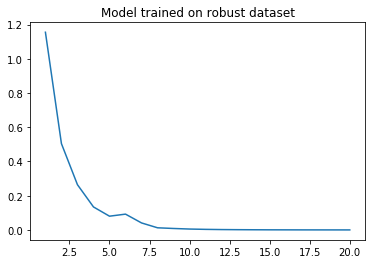

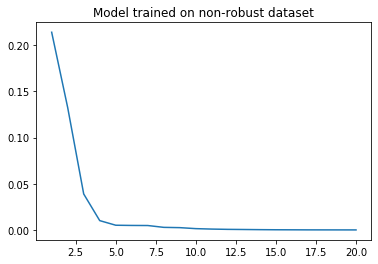

In [6]:
# Visualize the training process 
%matplotlib inline 
import matplotlib.pyplot as plt

y = [robust_loss_history[i] for i in np.arange(len(robust_loss_history)) if (i+1)%size_of_dataset==0]
x = [i+1 for i in np.arange(len(y))]
x = np.array(x)
plt.plot(x, y)
plt.title('Model trained on robust dataset')
plt.show()

y = [non_robust_loss_history[i] for i in np.arange(len(non_robust_loss_history)) if (i+1)%size_of_dataset==0]
x = [i+1 for i in np.arange(len(y))]
x = np.array(x)
plt.plot(x, y)
plt.title('Model trained on non-robust dataset')
plt.show()

In [7]:
# Measure attack success rate 
# 1. Design (apply) adversarial attacks 
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + (epsilon * sign_data_grad)
    # Return the perturbed image
    return perturbed_image

def test(model, epsilon, X, Y, verbose=False):

    # Accuracy counter
    correct = 0
    success_count = 0
    adv_examples = []

    # Loop over all examples in test set
    for idx, data in enumerate(X):
        data = torch.from_numpy(np.expand_dims(data, axis=0).astype(np.float32))
        target = np.array([Y[idx]]).astype(np.int64)
        target = torch.from_numpy(target)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model.forward(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model.forward(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
        else:
            success_count += 1

    # Calculate final accuracy for this epsilon
    final_sucess_rate = success_count/float(Y.shape[0])
    if verbose:
        print("Epsilon: {}\tSuccess Rate = {} / {} = {}".format(epsilon, success_count, Y.shape[0], final_sucess_rate))
    
    return final_sucess_rate

epsilons = [0, .01, .02, .03, .05, .1, .15, .2]
robust_pretrained_model = robust_model.eval()
non_robust_pretrained_model = non_robust_model.eval()
use_cuda=False

robust_attack_success_rate, non_robust_attack_success_rate = [], []
# Run test for each epsilon (robust)
for eps in epsilons:
    robust_attack_success_rate.append(test(robust_model, eps, test_X, test_Y, verbose=True))
    
print()
# Run test for each epsilon (non robust)
for eps in epsilons:
    non_robust_attack_success_rate.append(test(non_robust_model, eps, test_X, test_Y, verbose=True))

Epsilon: 0	Success Rate = 0 / 600 = 0.0
Epsilon: 0.01	Success Rate = 37 / 600 = 0.06166666666666667
Epsilon: 0.02	Success Rate = 81 / 600 = 0.135
Epsilon: 0.03	Success Rate = 134 / 600 = 0.22333333333333333
Epsilon: 0.05	Success Rate = 254 / 600 = 0.42333333333333334
Epsilon: 0.1	Success Rate = 485 / 600 = 0.8083333333333333
Epsilon: 0.15	Success Rate = 516 / 600 = 0.86
Epsilon: 0.2	Success Rate = 521 / 600 = 0.8683333333333333

Epsilon: 0	Success Rate = 0 / 600 = 0.0
Epsilon: 0.01	Success Rate = 48 / 600 = 0.08
Epsilon: 0.02	Success Rate = 98 / 600 = 0.16333333333333333
Epsilon: 0.03	Success Rate = 144 / 600 = 0.24
Epsilon: 0.05	Success Rate = 286 / 600 = 0.4766666666666667
Epsilon: 0.1	Success Rate = 490 / 600 = 0.8166666666666667
Epsilon: 0.15	Success Rate = 512 / 600 = 0.8533333333333334
Epsilon: 0.2	Success Rate = 517 / 600 = 0.8616666666666667


In [8]:
print('Robustness indication (robust dataset):', robust_r)
print('Robustness indication (non robust dataset):', non_robust_r)

great_indication_count = 0
num_of_comparision = len(robust_attack_success_rate)
if robust_r < non_robust_r:
    for i in range(num_of_comparision):
        if robust_attack_success_rate[i] >= non_robust_attack_success_rate[i]:
            great_indication_count += 1
elif robust_r > non_robust_r:
    for i in range(num_of_comparision):
        if robust_attack_success_rate[i] <= non_robust_attack_success_rate[i]:
            great_indication_count += 1
else:
    print('Weird, it merely impossible for two robustness indication to the same!')

print(great_indication_count, num_of_comparision, great_indication_count/num_of_comparision)

Robustness indication (robust dataset): -94.54466962814331
Robustness indication (non robust dataset): -92.76857137680054
3 8 0.375


In [9]:
num_of_trails = 30
cum_related_rate = 0

for trail_idx in range(num_of_trails):
    print('Trail:', trail_idx+1)

    size_of_dataset = 500
    robust_X, robust_Y = create_robust_dataset(size_of_dataset)
    non_robust_X, non_robust_Y = create_non_robust_dataset(size_of_dataset)

    robust_r = compute_robustness_indication(robust_X, robust_Y)
    non_robust_r = compute_robustness_indication(non_robust_X, non_robust_Y)

    robust_loss_history, robust_model = generate_NaiveC(robust_X, robust_Y)
    non_robust_loss_history, non_robust_model = generate_NaiveC(non_robust_X, non_robust_Y)

    
#     epsilons = [.02, .03, 0.5, 0.8, .1]
    epsilons = [.1]
    
    
    robust_pretrained_model = robust_model.eval()
    non_robust_pretrained_model = non_robust_model.eval()
    use_cuda=False

    robust_attack_success_rate, non_robust_attack_success_rate = [], []
    # Run test for each epsilon (robust)
    for eps in epsilons:
        robust_attack_success_rate.append(test(robust_model, eps, test_X, test_Y))

    # Run test for each epsilon (non robust)
    for eps in epsilons:
        non_robust_attack_success_rate.append(test(non_robust_model, eps, test_X, test_Y))

    great_indication_count = 0
    num_of_comparision = len(robust_attack_success_rate)
    if robust_r < non_robust_r:
        for i in range(num_of_comparision):
            if robust_attack_success_rate[i] >= non_robust_attack_success_rate[i]:
                great_indication_count += 1
    elif robust_r > non_robust_r:
        for i in range(num_of_comparision):
            if robust_attack_success_rate[i] <= non_robust_attack_success_rate[i]:
                great_indication_count += 1
    else:
        print('Weird, it merely impossible for two robustness indication to the same!')

    print(great_indication_count, num_of_comparision, great_indication_count/num_of_comparision)
    cum_related_rate += great_indication_count/num_of_comparision
    
print(cum_related_rate/num_of_trails)

Trail: 1
close i: 5 close i distance: 5.145535
close i: 5 close i distance: 4.8152976
close i: 8 close i distance: 4.4816327
close i: 5 close i distance: 4.1064816
close i: 9 close i distance: 3.1636264
close i: 9 close i distance: 3.5720055
close i: 2 close i distance: 4.510022
close i: 9 close i distance: 3.27083
close i: 5 close i distance: 3.976643
close i: 4 close i distance: 3.1636264
close i: 5 close i distance: 4.9977565
close i: 5 close i distance: 5.497537
close i: 6 close i distance: 4.8096504
close i: 5 close i distance: 4.1739335
close i: 9 close i distance: 3.7197506
close i: 3 close i distance: 4.1739335
close i: 2 close i distance: 4.8096504
close i: 9 close i distance: 3.7872386
close i: 5 close i distance: 4.305681
close i: 4 close i distance: 3.7197506
1 1 1.0
Trail: 2
close i: 5 close i distance: 4.58886
close i: 8 close i distance: 4.569581
close i: 8 close i distance: 4.2235193
close i: 5 close i distance: 3.6732428
close i: 9 close i distance: 3.3243787
close i: 

1 1 1.0
Trail: 12
close i: 5 close i distance: 4.805987
close i: 8 close i distance: 5.483474
close i: 8 close i distance: 4.6727433
close i: 5 close i distance: 4.098087
close i: 9 close i distance: 2.771355
close i: 8 close i distance: 3.667379
close i: 8 close i distance: 4.9310474
close i: 9 close i distance: 3.2533712
close i: 5 close i distance: 3.667379
close i: 4 close i distance: 2.771355
close i: 5 close i distance: 4.58886
close i: 8 close i distance: 4.569581
close i: 8 close i distance: 4.2235193
close i: 5 close i distance: 3.6732428
close i: 9 close i distance: 3.3243787
close i: 8 close i distance: 3.5834181
close i: 4 close i distance: 4.6521735
close i: 9 close i distance: 3.528783
close i: 5 close i distance: 3.5834181
close i: 4 close i distance: 3.3243787
1 1 1.0
Trail: 13
close i: 5 close i distance: 4.706465
close i: 8 close i distance: 5.049523
close i: 6 close i distance: 4.2211876
close i: 5 close i distance: 3.916294
close i: 9 close i distance: 2.9148676
clo

1 1 1.0
Trail: 23
close i: 5 close i distance: 5.3620815
close i: 9 close i distance: 6.0020175
close i: 8 close i distance: 5.1486087
close i: 5 close i distance: 3.9753015
close i: 9 close i distance: 3.7159004
close i: 3 close i distance: 3.9753015
close i: 2 close i distance: 5.5888085
close i: 9 close i distance: 3.840265
close i: 5 close i distance: 4.4349675
close i: 4 close i distance: 3.7159004
close i: 5 close i distance: 5.8100214
close i: 5 close i distance: 4.1707473
close i: 6 close i distance: 4.5457726
close i: 5 close i distance: 3.763517
close i: 9 close i distance: 3.396196
close i: 8 close i distance: 3.2575526
close i: 5 close i distance: 4.5445127
close i: 9 close i distance: 4.0240064
close i: 5 close i distance: 3.2575526
close i: 4 close i distance: 3.396196
1 1 1.0
Trail: 24
close i: 5 close i distance: 5.089249
close i: 5 close i distance: 4.3816767
close i: 8 close i distance: 3.8670256
close i: 5 close i distance: 4.2223797
close i: 9 close i distance: 3.05